In [27]:
from os import listdir, path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import dates as pltdates
from matplotlib import colors as pltcolors
from datetime import datetime as dt

In [6]:
date_i_want = dt(2022, 6, 16)

In [7]:
tfm602 = xr.open_dataset(f'/Volumes/LtgSSD/tobac_saves/tobac_Save_{date_i_want.strftime("%Y%m%d")}/seabreeze.zarr', engine='zarr')
tfm602

<xarray.Dataset> Size: 4GB
Dimensions:                           (feature: 4262, cell: 235, x: 1001,
                                       y: 1001, time: 293, track: 178)
Coordinates:
  * cell                              (cell) int64 2kB -1 5 18 ... 1554 1604
  * feature                           (feature) int64 34kB 1 2 3 ... 4261 4262
  * time                              (time) datetime64[ns] 2kB 2022-06-16T00...
  * track                             (track) float64 1kB 0.0 1.0 ... 177.0
  * x                                 (x) float64 8kB -2.5e+05 ... 2.5e+05
  * y                                 (y) float64 8kB -2.5e+05 ... 2.5e+05
Data variables: (12/51)
    avg_L2-MCMIPC                     (feature) float64 34kB ...
    cell_child_feature_count          (cell) float64 2kB ...
    cell_parent_track_id              (cell) float64 2kB ...
    feature_area                      (feature) float64 34kB ...
    feature_echotop                   (feature) int64 34kB ...
    feature_flash_count               (feature) float64 34kB ...
    ...                                ...
    min_L2-MCMIPC                     (feature) float64 34kB ...
    seabreeze                         (time, y, x) float32 1GB ...
    segmentation_mask                 (time, y, x) float32 1GB ...
    segmentation_mask_cell            (time, y, x) float32 1GB ...
    std_L2-MCMIPC                     (feature) float64 34kB ...
    track_child_cell_count            (track) float64 1kB ...
Attributes:
    center_lat:  29.47
    center_lon:  -95.08

In [8]:
arm_sonde_path = '/Volumes/LtgSSD/arm-sondes/'
sonde_files = sorted(listdir(arm_sonde_path))
sonde_files = [f for f in sonde_files if date_i_want.strftime('%Y%m%d') in f]
sonde_dts = [dt.strptime(' '.join(f.split('.')[2:4]), '%Y%m%d %H%M%S') for f in sonde_files]
sonde_files = [path.join(arm_sonde_path, f) for f in sonde_files]
laporte_sondes = [f for f in sonde_files if 'M1.b1' in f or 'S1.b1' in f]
guy_sondes = [f for f in sonde_files if 'S3.b1' in f or 'S4.b1' in f]

sonde_lons = []
sonde_lats = []

for i in range(len(sonde_files)):
    tmp_sonde = xr.open_dataset(sonde_files[i])
    sonde_lons.append(tmp_sonde.lon.data[0])
    sonde_lats.append(tmp_sonde.lat.data[0])

sonde_lons = np.array(sonde_lons)
sonde_lats = np.array(sonde_lats)

In [9]:
ccn_602 = xr.open_dataset(f'/Volumes/LtgSSD/arm-ccn/houaosccn200M1.a1.{date_i_want.strftime("%Y%m%d")}.000000.nc')

In [10]:
ccn_602.N_CCN_1.data

array([1721.95, 1735.44, 1693.45, ..., 2514.33, 2426.76, 2515.52],
      dtype=float32)

In [11]:
ccn_602

<xarray.Dataset> Size: 36MB
Dimensions:                            (time: 86400, size_bin: 20, bound: 2)
Coordinates:
  * time                               (time) datetime64[ns] 691kB 2022-06-16...
  * size_bin                           (size_bin) float32 80B 0.0 1.0 ... 19.0
Dimensions without coordinates: bound
Data variables: (12/62)
    base_time                          datetime64[ns] 8B ...
    time_offset                        (time) datetime64[ns] 691kB ...
    size_bin_bounds                    (size_bin, bound) float32 160B ...
    CCN_supersaturation_set_point_1    (time) float32 346kB ...
    CCN_temp_unstable_1                (time) float64 691kB ...
    CCN_temperature_gradient_1         (time) float32 346kB ...
    ...                                 ...
    CCN_proportional_valve_voltage_2   (time) float32 346kB ...
    CCN_alarm_code_1                   (time) float64 691kB ...
    CCN_alarm_code_2                   (time) float64 691kB ...
    lat                                float32 4B ...
    lon                                float32 4B ...
    alt                                float32 4B ...
Attributes: (12/18)
    command_line:                aosccn200_ingest -s hou -f M1
    Conventions:                 ARM-1.3
    process_version:             ingest-aosccn200-1.4-1.el7
    dod_version:                 aosccn200-a1-2.7
    site_id:                     hou
    facility_id:                 M1
    ...                          ...
    mentor_name:                 Uin
    mentor_affiliation:          BNL
    serial_number:               1109-012/WD22971
    sampling_interval:           1 second
    doi:                         10.5439/1223287
    history:                     created by user dsmgr on machine procnode1 a...

In [12]:
is_seabreeze = []
ccn_lat, ccn_lon = ccn_602.lat.data.item(), ccn_602.lon.data.item()
ll_distance = ((ccn_lat - tfm602.lat.data)**2 + (ccn_lon - tfm602.lon.data)**2)**0.5
ccn_xi, ccn_yi = np.unravel_index(np.argmin(ll_distance), ll_distance.shape)
times_maritime = tfm602.time.data[tfm602.seabreeze[:, ccn_yi, ccn_xi] == -2]
times_continental = tfm602.time.data[tfm602.seabreeze[:, ccn_yi, ccn_xi] > -2]

In [13]:
is_continental = ((ccn_602.time.data < times_maritime[-2]).astype(int) * -2) + 1
is_continental

array([-1, -1, -1, ...,  1,  1,  1])

In [14]:
pctsuper = (ccn_602.CCN_supersaturation_set_point_1.data == 1)

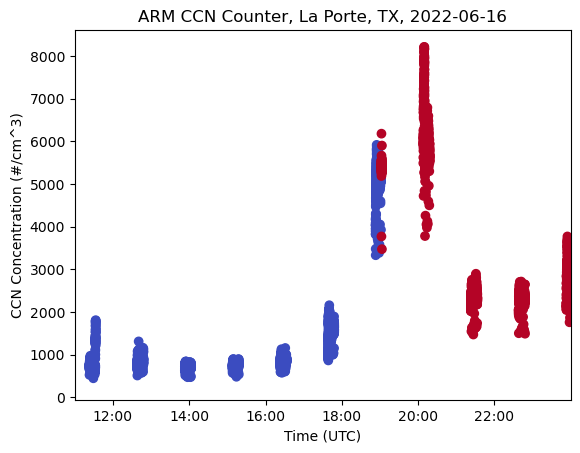

In [15]:
ccn_fig = plt.figure()
ccn_ax = ccn_fig.gca()

ccn_ax.scatter(ccn_602.time.data[pctsuper], ccn_602.N_CCN_1.data[pctsuper], c=is_continental[pctsuper], cmap='coolwarm')
ccn_ax.set_ylabel('CCN Concentration (#/cm^3)')
ccn_ax.set_xlabel('Time (UTC)')
ccn_ax.set_xlim(np.datetime64(f'{date_i_want.strftime('%Y-%m-%d')}T11:00:00'), np.datetime64(f'{date_i_want.strftime('%Y-%m-%d')}T23:59:59'))
ccn_ax.set_title(f'ARM CCN Counter, La Porte, TX, {date_i_want.strftime("%Y-%m-%d")}')
ccn_ax.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M'))

In [16]:
lma = xr.open_dataset(f'/Volumes/LtgSSD/{date_i_want.strftime('%B').lower()}/6sensor_minimum/LYLOUT_{date_i_want.strftime('%y%m%d_000000')}_86400_map500m.nc')

In [ ]:
maritime_flash_times = []
continental_flash_times = []
for flash in range(len(lma.number_of_flashes.data)):
    flash_time = lma.flash_time_start.data[flash]
    flash_lat = lma.flash_init_latitude.data[flash]
    flash_lon = lma.flash_init_longitude.data[flash]
    # filter byy number of points
    # separate by large and small flashes at 4km (Bruning + MacGorman 2013)
    closest_seabreeze = tfm602.sel(time=flash_time, method='nearest')
    distance_to_seabreeze = ((flash_lat - closest_seabreeze.lat.data)**2 + (flash_lon - closest_seabreeze.lon.data)**2)**0.5
    xi, yi = np.unravel_index(np.argmin(distance_to_seabreeze), distance_to_seabreeze.shape)
    seabreeze_value = closest_seabreeze.seabreeze.isel(x=xi, y=yi).data.item()
    if seabreeze_value == -2:
        maritime_flash_times.append(flash_time)
    else:
        continental_flash_times.append(flash_time)

In [18]:
times_of_maritime = np.sort(np.array(maritime_flash_times))
maritime_flash_count = np.arange(1, len(times_of_maritime) + 1)
times_of_continental = np.sort(np.array(continental_flash_times))
continental_flash_count = np.arange(1, len(times_of_continental) + 1)

maritime_density = 60*(maritime_flash_count / (times_of_maritime - times_of_maritime[0]).astype('timedelta64[s]').astype(float))
continental_density = 60*(continental_flash_count / (times_of_continental - times_of_continental[0]).astype('timedelta64[s]').astype(float))

/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_56916/4198195996.py:6: RuntimeWarning: divide by zero encountered in divide
  maritime_density = 60*(maritime_flash_count / (times_of_maritime - times_of_maritime[0]).astype('timedelta64[s]').astype(float))
/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_56916/4198195996.py:7: RuntimeWarning: divide by zero encountered in divide
  continental_density = 60*(continental_flash_count / (times_of_continental - times_of_continental[0]).astype('timedelta64[s]').astype(float))


In [19]:
all_flash_times = np.sort(lma.flash_time_start.data)
all_flash_count = np.arange(1, len(all_flash_times) + 1)
all_flash_density = 60*(all_flash_count / (all_flash_times - all_flash_times[0]).astype('timedelta64[s]').astype(float))

/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_56916/308374755.py:3: RuntimeWarning: divide by zero encountered in divide
  all_flash_density = 60*(all_flash_count / (all_flash_times - all_flash_times[0]).astype('timedelta64[s]').astype(float))


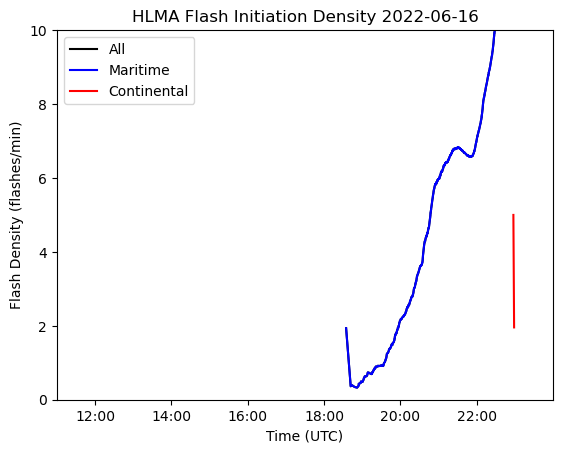

In [20]:
density_fig = plt.figure()
density_ax = density_fig.gca()

density_ax.plot(all_flash_times, all_flash_density, label='All', color='black')
density_ax.plot(times_of_maritime, maritime_density, label='Maritime', color='blue')
density_ax.plot(times_of_continental, continental_density, label='Continental', color='red')

density_ax.set_ylabel('Flash Density (flashes/min)')
density_ax.set_xlabel('Time (UTC)')
density_ax.set_xlim(np.datetime64(f'{date_i_want.strftime('%Y-%m-%d')}T11:00:00'), np.datetime64(f'{date_i_want.strftime('%Y-%m-%d')}T23:59:59'))
density_ax.set_ylim(0, 10)
density_ax.set_title(f'HLMA Flash Initiation Density {date_i_want.strftime('%Y-%m-%d')}')
density_ax.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M'))
density_ax.legend()

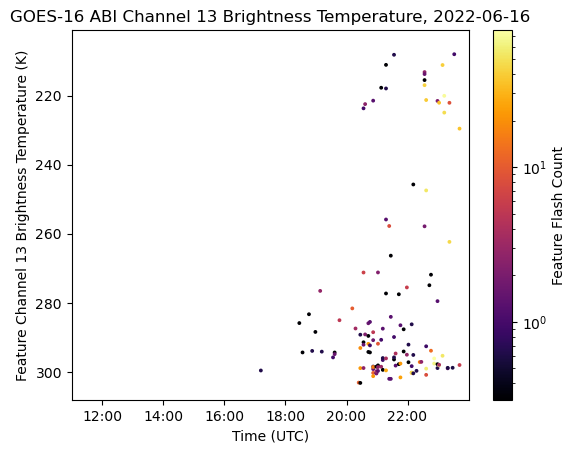

In [30]:
fig = plt.figure()
ax = fig.gca()

sct = ax.scatter(tfm602.feature_time.data, tfm602['avg_L2-MCMIPC'].data, c=tfm602.feature_flash_count, cmap='inferno', s=3, norm=pltcolors.LogNorm())
ax.set_ylabel('Feature Channel 13 Brightness Temperature (K)')
ax.set_xlabel('Time (UTC)')
ax.set_xlim(np.datetime64(f'{date_i_want.strftime('%Y-%m-%d')}T11:00:00'), np.datetime64(f'{date_i_want.strftime('%Y-%m-%d')}T23:59:59'))
ax.set_title(f'GOES-16 ABI Channel 13 Brightness Temperature, {date_i_want.strftime('%Y-%m-%d')}')
ax.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M'))
ax.invert_yaxis()
fig.colorbar(sct, label='Feature Flash Count')